This document covers:

* **Learning Curves:** Explains their purpose (diagnosing `bias`/`variance` relative to data size) and interpretation. Demonstrates how to generate the data using `sklearn.model_selection.learning_curve` and plot the results, showing training and `cross-validation` scores against the number of training samples.
* **Validation Curves:** Explains their purpose (analyzing the impact of a single `hyperparameter`) and interpretation. Demonstrates how to generate the data using `sklearn.model_selection.validation_curve` and plot the results, showing training and `cross-validation` scores against different values of the chosen `hyperparameter`.
* **Pipelines:** Shows the importance of using `pipelines` (here, `make_pipeline`) with `learning_curve` and `validation_curve` to ensure preprocessing steps like scaling are applied correctly within the internal `cross-validation` loops.

These visual tools complement the numerical metrics discussed earlier, providing valuable insights for diagnosing issues and guiding model improvement efforts.

--- Loading Digits Dataset ---
Data shape: X=(1797, 64), y=(1797,)
------------------------------
--- Generating Learning Curve Data ---
Learning curve scores calculated.

--- Plotting Learning Curve ---


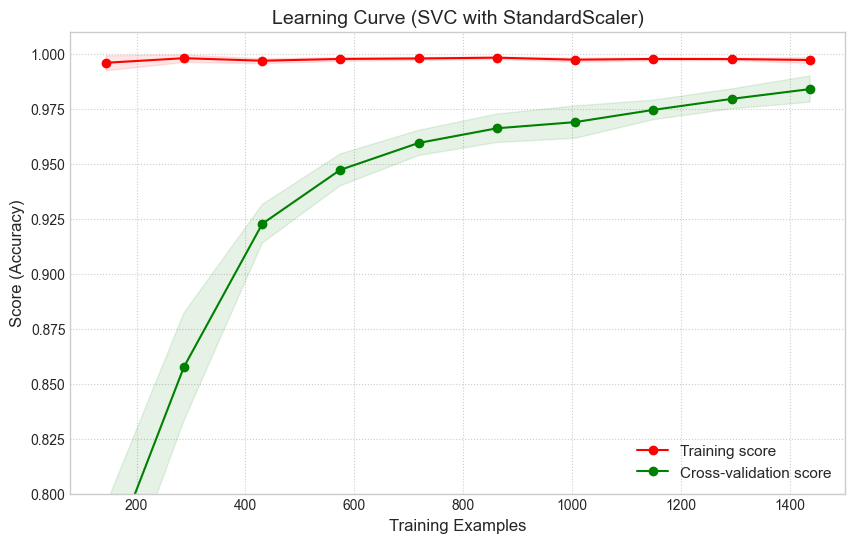

Generated Learning Curve Plot.
------------------------------
--- Generating Validation Curve Data ---
Validation curve scores calculated.

--- Plotting Validation Curve ---


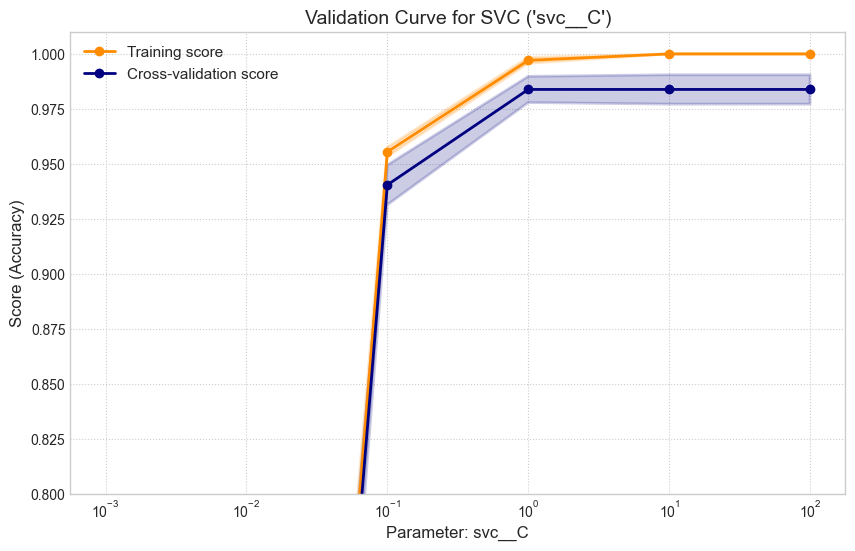

Generated Validation Curve Plot.
------------------------------


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits # Using digits dataset for clearer curves
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # Example model (sensitive to hyperparameters)
from sklearn.pipeline import make_pipeline # Useful for including scaler in CV

# --- 1. Load and Prepare Data ---
print("--- Loading Digits Dataset ---")
digits = load_digits()
X, y = digits.data, digits.target

# Using the entire dataset for demonstration, but typically you'd use
# the training portion after an initial train-test split.
# Scaling is important for SVC
# We use a pipeline to ensure scaling happens correctly within CV for these plots
pipeline = make_pipeline(StandardScaler(), SVC(gamma='scale', random_state=42))

print(f"Data shape: X={X.shape}, y={y.shape}")
print("-" * 30)


# --- 2. Learning Curves ---
# Purpose: Diagnose bias vs. variance by plotting model performance (e.g., accuracy)
#          on training and validation sets against varying amounts of training data.
# Interpretation:
# - High Bias (Underfitting): Both training and validation scores converge to a low value.
#   Adding more data likely won't help much. Suggests needing a more complex model or better features.
# - High Variance (Overfitting): Large gap between a high training score and a lower validation score.
#   The validation score might improve as more data is added. Suggests needing more data,
#   simplifying the model, or using regularization.
# - Just Right: Both scores converge to a high value with a small gap between them.

print("--- Generating Learning Curve Data ---")
# Define training sizes (proportions or absolute numbers)
train_sizes_abs = np.linspace(0.1, 1.0, 10) # Relative sizes from 10% to 100%

# Define CV strategy (e.g., Stratified K-Fold for classification)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate learning curve scores
# Uses cross-validation internally for each training size subset.
# Returns: train_sizes (absolute number of samples), train_scores (scores on training subsets),
#          validation_scores (scores on validation folds corresponding to each training subset)
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=pipeline, # Use the pipeline (scaler + SVC)
    X=X,
    y=y,
    train_sizes=train_sizes_abs,
    cv=cv_strategy,
    scoring='accuracy', # Or other relevant metric
    n_jobs=-1, # Use all available CPU cores
    random_state=42 # Ensure reproducibility of subset selection if cv shuffles
)

# Calculate mean and standard deviation for plotting bands
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

print("Learning curve scores calculated.")

# Plotting the Learning Curve
print("\n--- Plotting Learning Curve ---")
plt.style.use('seaborn-v0_8-whitegrid') # Use a seaborn style
plt.figure(figsize=(10, 6))

# Plot mean accuracy lines
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

# Plot accuracy bands (mean +/- std dev)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

# Customize the plot
plt.title("Learning Curve (SVC with StandardScaler)", fontsize=14)
plt.xlabel("Training Examples", fontsize=12)
plt.ylabel("Score (Accuracy)", fontsize=12)
plt.legend(loc="best", fontsize=11)
plt.grid(True, linestyle=':')
plt.ylim(0.8, 1.01) # Adjust y-limit for better visibility
plt.show()
print("Generated Learning Curve Plot.")
# Interpretation Note: For this SVC on digits, likely shows good convergence,
# indicating sufficient data and reasonable complexity. If validation score stayed low
# while training score was high, it would indicate high variance (overfitting).
# If both stayed low, it would indicate high bias (underfitting).
print("-" * 30)


# --- 3. Validation Curves ---
# Purpose: Evaluate how model performance changes with variations in a *single* hyperparameter.
#          Helps understand sensitivity to a parameter and identify potential overfitting/underfitting
#          related to that specific parameter's value.
# Interpretation:
# - Find the "sweet spot": Look for parameter values where the validation score is maximized.
# - Identify Overfitting Range: Where training score remains high/improves, but validation score decreases/plateaus.
# - Identify Underfitting Range: Where both training and validation scores are low (often for low complexity parameter values).

print("--- Generating Validation Curve Data ---")

# Define the hyperparameter and the range of values to test
# Example: Tuning the 'C' parameter (regularization strength) for SVC
param_name = 'svc__C' # Parameter name within the pipeline ('estimatorName__parameterName')
param_range = np.logspace(-3, 2, 6) # Test C values from 0.001 to 100 on a log scale

# Calculate validation curve scores
# Uses cross-validation internally for each parameter value.
# Returns: train_scores (scores on training subsets), validation_scores (scores on validation folds)
train_scores_vc, validation_scores_vc = validation_curve(
    estimator=pipeline, # Use the pipeline
    X=X,
    y=y,
    param_name=param_name,
    param_range=param_range,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_vc_mean = np.mean(train_scores_vc, axis=1)
train_scores_vc_std = np.std(train_scores_vc, axis=1)
validation_scores_vc_mean = np.mean(validation_scores_vc, axis=1)
validation_scores_vc_std = np.std(validation_scores_vc, axis=1)

print("Validation curve scores calculated.")

# Plotting the Validation Curve
print("\n--- Plotting Validation Curve ---")
plt.figure(figsize=(10, 6))

# Plot mean accuracy lines
plt.semilogx(param_range, train_scores_vc_mean, 'o-', color="darkorange", lw=2, label="Training score") # Use semilogx for log-spaced range
plt.semilogx(param_range, validation_scores_vc_mean, 'o-', color="navy", lw=2, label="Cross-validation score")

# Plot accuracy bands
plt.fill_between(param_range, train_scores_vc_mean - train_scores_vc_std,
                 train_scores_vc_mean + train_scores_vc_std, alpha=0.2, color="darkorange", lw=2)
plt.fill_between(param_range, validation_scores_vc_mean - validation_scores_vc_std,
                 validation_scores_vc_mean + validation_scores_vc_std, alpha=0.2, color="navy", lw=2)

# Customize the plot
plt.title(f"Validation Curve for SVC ('{param_name}')", fontsize=14)
plt.xlabel(f"Parameter: {param_name}", fontsize=12)
plt.ylabel("Score (Accuracy)", fontsize=12)
plt.legend(loc="best", fontsize=11)
plt.grid(True, linestyle=':')
plt.ylim(0.8, 1.01)
plt.show()
print("Generated Validation Curve Plot.")
# Interpretation Note: Look for the peak in the validation score curve. If the gap
# between training and validation scores widens significantly as C increases, it indicates
# potential overfitting for high C values. If both scores are low for low C values,
# it might indicate underfitting (too much regularization).
print("-" * 30)